# Sentiment Analysis for Mental Health

## Importing Libraries

In [1]:
import re
import time
import spacy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score, precision_score, recall_score

## Reading the data

In [2]:
df = pd.read_csv('Combined Data.csv').drop(columns=['Unnamed: 0'])
df.head(10)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,Have you ever felt nervous but didn't know why?,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,"I'm really worried, I want to cry.",Anxiety


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [4]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [5]:
df = df.dropna(axis=0, how='any')

In [6]:
print("Number of rows and columns in the dataset: ", df.shape)

Number of rows and columns in the dataset:  (52681, 2)


## Exploratory Data Analysis (EDA)

In [7]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [8]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


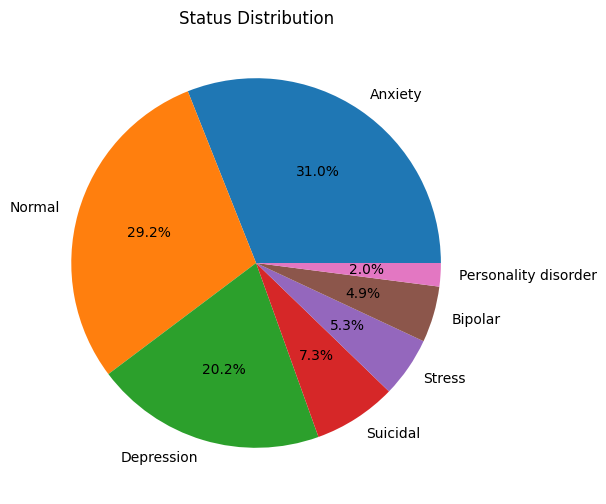

In [9]:
plt.figure(figsize=(6,6))
plt.pie(df['status'].value_counts(), labels=df['status'].unique(), autopct='%1.1f%%')
plt.title('Status Distribution')
plt.show()

In [10]:
df['statement_length'] = df['statement'].apply(lambda x: len(x.split()))

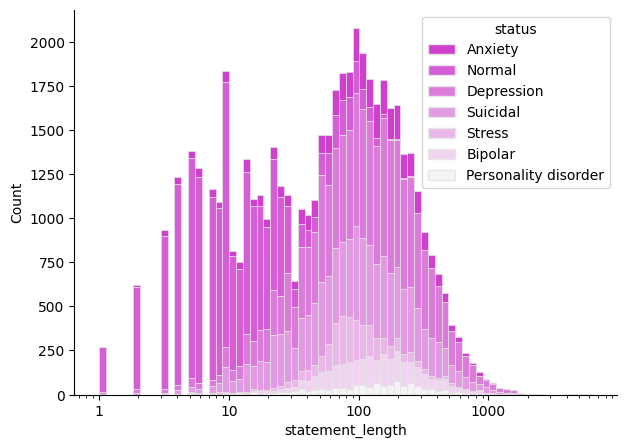

In [11]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df,
    x="statement_length", hue="status",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".9",
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

In [12]:
df['statement_length'].describe()

count    52681.000000
mean       113.158729
std        163.735305
min          1.000000
25%         15.000000
50%         62.000000
75%        148.000000
max       6300.000000
Name: statement_length, dtype: float64

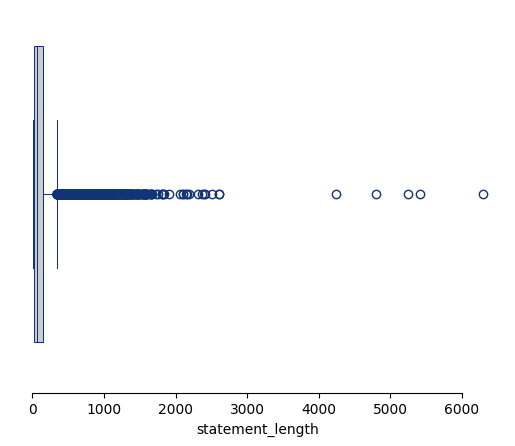

In [13]:
sns.boxplot(data=df, x="statement_length", color=".8", linecolor="#137", linewidth=.75)
sns.despine(offset=10, trim=True)

## Text Processing

#### Statement IQR

In [14]:
Q1 = df['statement_length'].quantile(0.25)
Q3 = df['statement_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['statement_length'] >= lower_bound) & (df['statement_length'] <= upper_bound)]

#### Statement Cleaning

In [15]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', '', text)
    
    # Remove URLs
    text = re.sub(r'(http|www)\S+', '', text)
    
    # Remove usernames
    text = re.sub(r'@\S+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters like $, &, etc.
    text = re.sub(r'[\$\&\%\*\@\#\!\?]', '', text)
    
    # Find emoticons
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Remove punctuations and non-alphabetic characters while preserving spaces and emoticons
    text = re.sub(r"[^a-zA-Z\s']", '', text)
    
    # Convert to lowercase and add emoticons back
    text = text.lower() + ' ' + ' '.join(emoticons).replace('-', '')
    
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize text using spaCy
    doc = nlp(text)
    
    # Lemmatize and remove stopwords
    cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    
    # Remove words with only 1 character
    cleaned_text = re.sub(r'\b\w\b', '', cleaned_text)

    # Remove apostrophes but prevent additional spaces
    cleaned_text = re.sub(r"\s+'|'\s+", ' ', cleaned_text).strip()
    
    return cleaned_text

In [16]:
df['cleaned_statement'] = np.vectorize(preprocess_text)(df['statement'])

In [17]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

## Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_statement'], df['status'], test_size=0.2, random_state=42)

## Term Frequency-Inverse Document Frequency (TF-IDF)

In [19]:
tfidf = TfidfVectorizer(use_idf=True, norm= 'l2', smooth_idf=True)
X_train, X_test = tfidf.fit_transform(X_train), tfidf.transform(X_test)

## Over-Sampling

In [20]:
smote = SMOTE(random_state=42)
X_re_sampled, y_re_sampled = smote.fit_resample(X_train, y_train)

In [21]:
print(f"SMOTE: {Counter(y_re_sampled)}")

SMOTE: Counter({'Anxiety': 12785, 'Suicidal': 12785, 'Normal': 12785, 'Depression': 12785, 'Stress': 12785, 'Bipolar': 12785, 'Personality disorder': 12785})


## Modelling

In [22]:
classification_models: dict = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=1000)
}

## K-Fold Cross Validation

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Training Model

In [24]:
def evaluate_classification_models(x_train: pd.DataFrame, y_train: pd.Series, models, cv: int = 5):
    """
    Evaluates a list of models using cross-validation, stores results, and returns a DataFrame for comparison.

    Args:
        x_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        models (list): A list of scikit-learn model objects.
        cv (int): Number of cross-validation folds. Default is 5.

    Returns:
        pd.DataFrame: A DataFrame containing model names and evaluation metrics.
    """
    
    metric_evaluation = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro', zero_division=1),
        'recall': make_scorer(recall_score, average='macro', zero_division=1),
        'precision': make_scorer(precision_score, average='macro', zero_division=1),
    }
    model_results = []
    for model_name, model in tqdm(models.items()):
        start_time = time.time()
        cv_results = cross_validate(model, x_train, y_train, scoring=metric_evaluation, cv=cv, return_train_score=False, n_jobs=-1) 
        training_time = time.time() - start_time

        model_results.append({
            "Model-Name": model_name,
            "Accuracy Mean": cv_results['test_accuracy'].mean() * 100,
            "Accuracy Std": cv_results['test_accuracy'].std() * 100,
            "F1_Score Mean": cv_results['test_f1'].mean(),
            "F1_Score Std": cv_results['test_f1'].std(),
            "Precision Mean": cv_results['test_precision'].mean(),
            "Precision Std": cv_results['test_precision'].std(),
            "Recall Mean": cv_results['test_recall'].mean(),
            "Recall Std": cv_results['test_recall'].std(),
            "Training Time (s)": training_time
        })

    df_models_score = pd.DataFrame(model_results).set_index('Model-Name').sort_values("F1_Score Mean", ascending=False)
    
    return df_models_score.sort_values("F1_Score Mean", ascending=False)

In [25]:
df_models_score = evaluate_classification_models(X_re_sampled, y_re_sampled, classification_models, cv=kfold)

100%|██████████| 11/11 [5:22:52<00:00, 1761.18s/it] 


In [26]:
df_models_score

,Accuracy Mean,Accuracy Std,F1_Score Mean,F1_Score Std,Precision Mean,Precision Std,Recall Mean,Recall Std,Training Time (s)
Model-Name,,,,,,,,,
ExtraTreesClassifier,92.367171,0.158629,0.922449,0.001392,0.923257,0.001565,0.923670,0.001379,986.351300
SVC,92.299011,0.195289,0.922248,0.001684,0.922504,0.001734,0.922984,0.001738,3110.773272
MLPClassifier,91.504553,0.173594,0.913208,0.001873,0.912971,0.001743,0.915064,0.001715,9996.615614
RandomForestClassifier,91.040840,0.131671,0.908892,0.001610,0.911403,0.001626,0.910403,0.001468,611.053428
LogisticRegression,87.096486,0.161019,0.868249,0.001415,0.868188,0.001565,0.870974,0.001430,30.908529
BaggingClassifier,84.317560,0.140541,0.841288,0.001701,0.840187,0.001675,0.843168,0.001726,1051.847997
SGDClassifier,84.160009,0.134615,0.833940,0.001280,0.841880,0.001364,0.841614,0.000833,5.110689
DecisionTreeClassifier,80.509526,0.233439,0.803584,0.001534,0.802614,0.001558,0.805109,0.001674,119.431770
GradientBoostingClassifier,80.119560,0.176977,0.800036,0.001560,0.803307,0.001425,0.801212,0.001839,3297.142758


## Evaluation

In [27]:
def evaluate_classification_metrics(y_true, y_pred, target_names=None, display=True, figsize=(8, 9)):
    """
    Evaluates a classification model by generating a confusion matrix, confusion matrix display (optional), and classification report.

    Args:
        y_true (pd.Series): Ground truth labels.
        y_pred (pd.Series): Predicted labels.
        target_names (list, optional): List of class names for improved readability of the confusion matrix. Defaults to None.
        display (bool, optional): Whether to display the confusion matrix visually using ConfusionMatrixDisplay. Defaults to True.

    Returns:
        dict: A dictionary containing the confusion matrix, classification report, and class names (if provided).
    """

    # Ensure y_true and y_pred are NumPy arrays for compatibility with sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=target_names, zero_division=1)

    # Optionally display confusion matrix visually
    if display:
        fig, ax = plt.subplots(figsize=figsize)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(ax=ax, xticks_rotation='vertical')
        plt.show()  # Display the confusion matrix plot

    # Return results in a dictionary for easy access
    evaluation_results = {
        "Confusion Matrix": cm,
        "Classification Report": report,
        "Target Names": target_names,  # Include target names if provided
    }
    return evaluation_results

In [28]:
best_algorithm_model = classification_models[df_models_score.index[0]]
best_algorithm_model.fit(X_re_sampled, y_re_sampled)
best_algorithm_prediction = best_algorithm_model.predict(X_test)

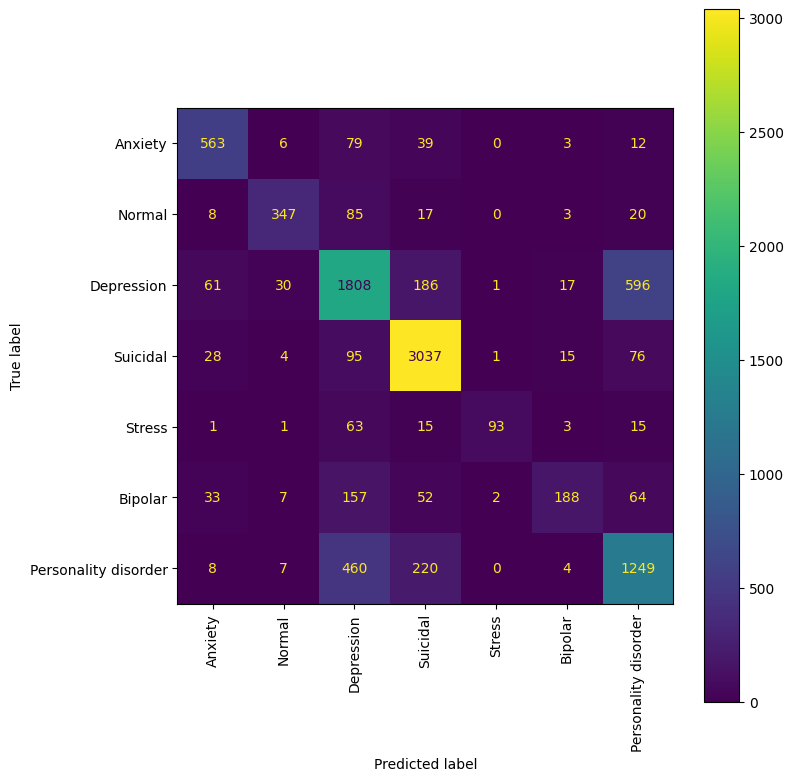

In [29]:
evaluation_results = evaluate_classification_metrics(y_test, best_algorithm_prediction, target_names=df['status'].unique(), display=True)

In [30]:
print(evaluation_results['Classification Report'])

                      precision    recall  f1-score   support

             Anxiety       0.80      0.80      0.80       702
              Normal       0.86      0.72      0.79       480
          Depression       0.66      0.67      0.66      2699
            Suicidal       0.85      0.93      0.89      3256
              Stress       0.96      0.49      0.65       191
             Bipolar       0.81      0.37      0.51       503
Personality disorder       0.61      0.64      0.63      1948

            accuracy                           0.74      9779
           macro avg       0.79      0.66      0.70      9779
        weighted avg       0.75      0.74      0.74      9779



## Fine-Tuning

### Randomized Search

In [31]:
metric_evaluation = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro', zero_division=1),
        'recall': make_scorer(recall_score, average='macro', zero_division=1),
        'precision': make_scorer(precision_score, average='macro', zero_division=1),
    }

In [ ]:
ExtraTreesClassifier(random_state=42)

In [32]:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_features': uniform(0.1, 0.9),
    'max_depth': [None, randint(5, 30)],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

In [34]:
random_search = RandomizedSearchCV(
    estimator= classification_models[df_models_score.index[0]],
    param_distributions=param_dist,
    scoring= metric_evaluation,
    refit='f1',
    cv=kfold,  
    random_state=42,
    n_iter=5, # Number of parameter settings that are sampled. Tip: more than 30 is better
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_re_sampled, y_re_sampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=19, max_features=0.7587945476302645, min_samples_leaf=5, min_samples_split=8, n_estimators=171; total time=96.2min
[CV] END bootstrap=True, criterion=entropy, max_depth=19, max_features=0.7587945476302645, min_samples_leaf=5, min_samples_split=8, n_estimators=171; total time=96.3min
[CV] END bootstrap=True, criterion=entropy, max_depth=19, max_features=0.7587945476302645, min_samples_leaf=5, min_samples_split=8, n_estimators=171; total time=96.7min
[CV] END bootstrap=True, criterion=entropy, max_depth=19, max_features=0.7587945476302645, min_samples_leaf=5, min_samples_split=8, n_estimators=171; total time=96.9min
[CV] END bootstrap=True, criterion=entropy, max_depth=19, max_features=0.7587945476302645, min_samples_leaf=5, min_samples_split=8, n_estimators=171; total time=97.0min
[CV] END bootstrap=True, criterion=gini, max_depth=14, max_features=0.1419990968922539, min_sam

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=ExtraTreesClassifier(random_state=42), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1733fa950>,
                                        'max_features': <scipy.stats._distn_infrastructure.r...
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1': make_scorer(f1_score, response_method='predict', average=macro, zero_division=1),
                            'precision': make_scorer(precision_score, response_method='predict', average=macro, zero_division=1),
                            'recall': make_scorer(recall_score, response_method='predict', average=macro, zero_division=1)},
                   verbose=2)

In [35]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print(f"Best Parameters: {best_params}")
print("Best Model Score:", best_model.score(X_test, y_test))

Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 0.6557333586649449, 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 394}
Best Model Score: 0.6879026485325698


In [36]:
best_model.fit(X_re_sampled, y_re_sampled)

best_prediction = best_model.predict(X_test)

print("F1_score", f1_score(y_test, best_prediction, average='macro'))
print("Accuracy", accuracy_score(y_test, best_prediction))

F1_score 0.638046589347608
Accuracy 0.6879026485325698


In [37]:
print(f'Classification Report: \n\n{classification_report(y_test, best_prediction)}')

Classification Report: 

                      precision    recall  f1-score   support

             Anxiety       0.66      0.72      0.69       702
             Bipolar       0.78      0.64      0.70       480
          Depression       0.71      0.53      0.61      2699
              Normal       0.74      0.94      0.83      3256
Personality disorder       0.70      0.58      0.64       191
              Stress       0.44      0.40      0.42       503
            Suicidal       0.60      0.57      0.58      1948

            accuracy                           0.69      9779
           macro avg       0.66      0.63      0.64      9779
        weighted avg       0.68      0.69      0.68      9779



## Saving Model

In [45]:
with open('Sentiment_Analysis_Mental-Health.pkl', 'wb') as model_dumps:
    pickle.dump(best_model, model_dumps)

#### Contibutor
> Piyawat Nulek (piyawat.nulek@icloud.com)